In [1]:
import numpy as np
import matplotlib.pyplot as plt
import import_ipynb

from fuel_garin import S_boost
from fuel_garin import S_sustain
from combustion_chumber import chumber

### Параметры двигателя

In [2]:
rho_t = 1800.0       # плотность топлива, кг/м^3
gamma = 1.22
R_gas = 8314.0 / 22.0  # газовая постоянная смеси, Дж/(кг*K)
T_flame = 3300.0       # температура газов, K

#### Сопло

In [3]:
At = 0.002   # критическое сечение, м²
Ae = 0.004   # выходное сечение, м²
Pa = 101325.0

#### Заряд звездочка

In [4]:
a_boost = 5e-5
n_boost = 0.35
R_outer = 0.075
r_inner0 = 0.025
A_star_amp = 0.003
k_star = 6
L_boost = 0.4

#### Заряд цилиндрический

In [5]:
a_sus = 3.5e-5
n_sus = 0.35
L_sus = 0.6

#### Масса ракеты

In [6]:
m_dry = 50.0

#### Параметры интегрирования

In [7]:
dt = 1e-4
t_max = 20.0

In [8]:
# массовый расход через сопло (с choked / unchoked)
def mdot_nozzle(P):
    if P <= Pa:
        return 0.0
    Pi_crit = (2.0/(gamma+1.0))**(gamma/(gamma-1.0))
    ratio = Pa/P

    if ratio <= Pi_crit:
        # задушенный режим
        return At*P*np.sqrt(gamma/(R_gas*T_flame))*(2.0/(gamma+1.0))**((gamma+1.0)/(2.0*(gamma-1.0)))
    else:

        # незадушенный режим
        term = (ratio**(2.0/gamma) - ratio**((gamma+1.0)/gamma))
        term = max(term, 0.0)
        return At*P*np.sqrt((2.0*gamma)/(R_gas*T_flame*(gamma-1.0))*term)

# скорость истечения для тяги
def v_exit(P):
    if P <= Pa:
        return 0.0
    ratio = Pa/P
    power = (gamma-1.0)/gamma
    term = 1.0 - ratio**power
    if term <= 0.0:
        return 0.0
    return np.sqrt((2.0*gamma/(gamma-1.0))*R_gas*T_flame*term)

# скорость горения
def burn_rate(P, regime):
    P_safe = max(P,1.0)
    if regime=="boost":
        return a_boost*(P_safe**n_boost)
    else:
        return a_sus*(P_safe**n_sus)

# ------------------ ИНИЦИАЛИЗАЦИЯ ------------------
t_arr=[]; P_arr=[]; F_arr=[]; mdot_arr=[]; m_arr=[]; S_arr=[]; r_arr=[]

P = 1e5      # стартовое давление
r_inner = r_inner0
V_cam = np.pi*(r_inner**2)*(L_boost+L_sus)
m_gas = P*V_cam/(R_gas*T_flame)

# масса топлива
V_fuel = np.pi*(R_outer**2-r_inner0**2)*(L_boost+L_sus)
m_fuel = rho_t*V_fuel

regime="boost"
t_switch=None
t_end=None

# интегрурирем
t=0.0
while t<=t_max:
    # выбор площади и rb
    if regime=="boost":
        S = S_boost(r_inner, A_star_amp, k_star, L_boost)
    else:
        S = S_sustain(r_inner, L_sus)
    rb = burn_rate(P, regime)
    m_dot_fuel = rho_t*S*rb if m_fuel>0 else 0.0

    # обновление массы топлива и радиуса
    m_fuel = max(m_fuel - m_dot_fuel*dt, 0.0)

    if m_fuel>0:
        r_inner += rb*dt
        if regime=="boost" and r_inner>=R_outer:
            regime="sustain"
            if t_switch is None:
                t_switch=t
    else:
        if t_end is None:
            t_end=t

    # расчёт давления через ДУ
    V_cam = np.pi*(r_inner**2)*(L_boost+L_sus)
    V_cam = max(V_cam,1e-8)
    m_dot_noz = mdot_nozzle(P)
    P = chumber(R_gas, T_flame, V_cam, m_dot_fuel, m_dot_noz, P, dt)
    P=max(P,Pa)
    
    # тяга
    v_e = v_exit(P)
    F = m_dot_noz*v_e+(P-Pa)*Ae

    # общая масса
    m_tot = m_dry+m_fuel

    # лог
    t_arr.append(t); P_arr.append(P/1e6); F_arr.append(F)
    mdot_arr.append(m_dot_fuel); m_arr.append(m_tot); S_arr.append(S); r_arr.append(r_inner)
    t+=dt


Время переключения boost→sustain: 7.250099999996442
Время окончания топлива: 11.283699999987041
P min/max (МПа): 0.101325 4.393310306537364
F min/max (Н): 0.0 30575.236049849984


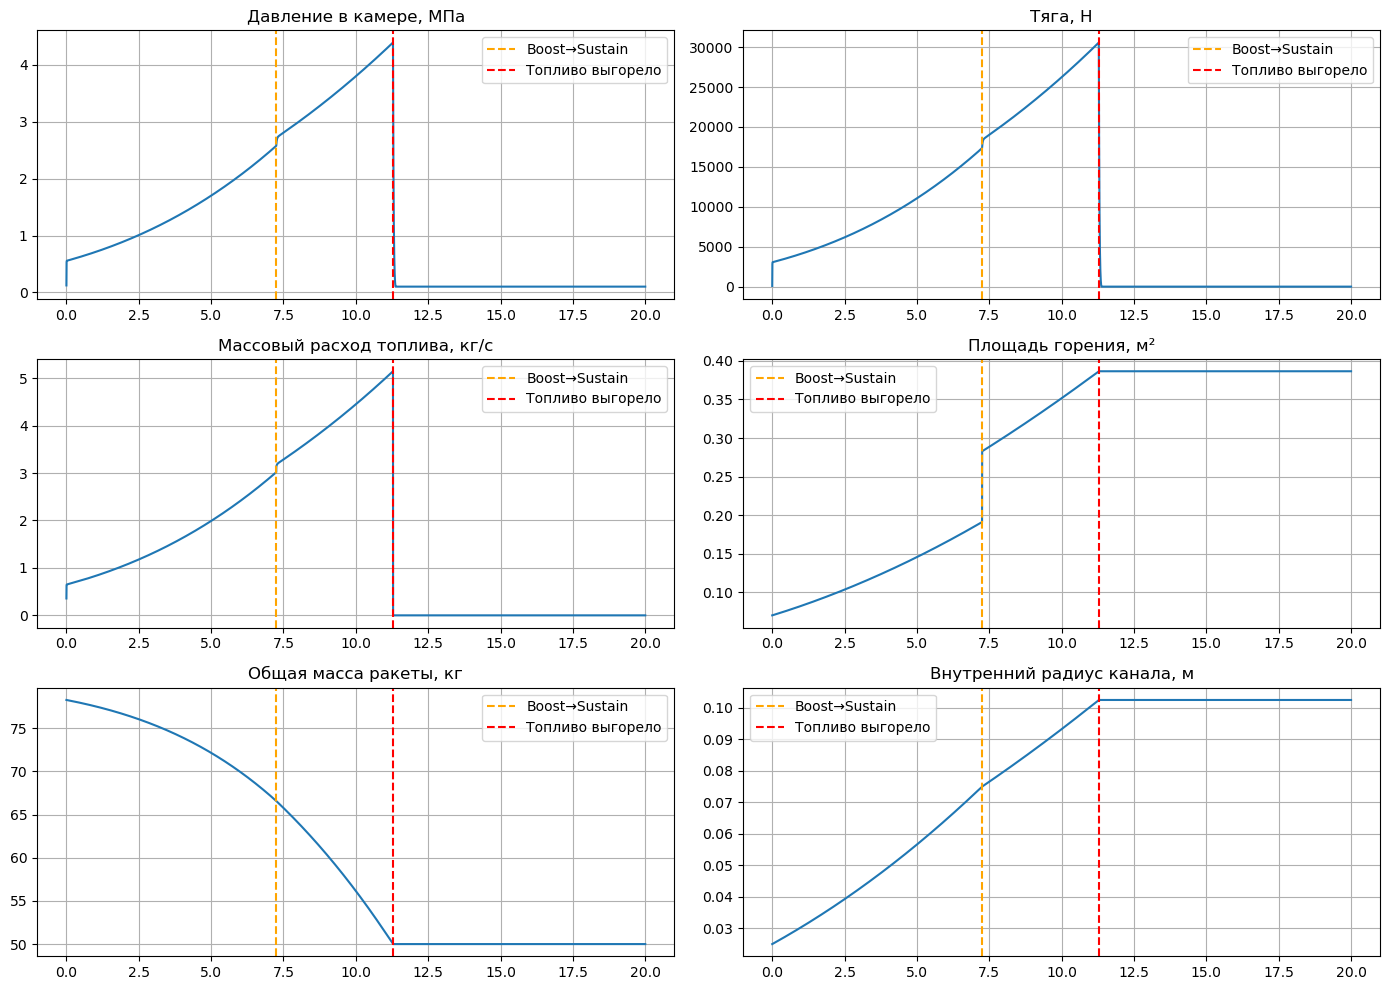

In [9]:
print("Время переключения boost→sustain:",t_switch)
print("Время окончания топлива:",t_end)
print("P min/max (МПа):",np.min(P_arr),np.max(P_arr))
print("F min/max (Н):",np.min(F_arr),np.max(F_arr))

fig,axs=plt.subplots(3,2,figsize=(14,10))
axs=axs.flatten()
axs[0].plot(t_arr,P_arr); axs[0].set_title("Давление в камере, МПа"); axs[0].grid()
axs[1].plot(t_arr,F_arr); axs[1].set_title("Тяга, Н"); axs[1].grid()
axs[2].plot(t_arr,mdot_arr); axs[2].set_title("Массовый расход топлива, кг/с"); axs[2].grid()
axs[3].plot(t_arr,S_arr); axs[3].set_title("Площадь горения, м²"); axs[3].grid()
axs[4].plot(t_arr,m_arr); axs[4].set_title("Общая масса ракеты, кг"); axs[4].grid()
axs[5].plot(t_arr,r_arr); axs[5].set_title("Внутренний радиус канала, м"); axs[5].grid()

for ax in axs:
    if t_switch is not None:
        ax.axvline(t_switch,color='orange',linestyle='--',label='Boost→Sustain')
    if t_end is not None:
        ax.axvline(t_end,color='red',linestyle='--',label='Топливо выгорело')
    ax.legend()


plt.tight_layout(); plt.show()